In [1]:
from typing import Optional
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset


class MyDataset(Dataset):
    def __init__(self, data, classes):
        super().__init__()
        self.data = torch.tensor(data, dtype=torch.float)
        self.classes = torch.tensor(classes, dtype=torch.long)

    def __getitem__(self, i):
        return self.data[i], self.classes[i]

    def __len__(self):
        return len(self.data)


class MyDataModule(pl.LightningDataModule):
    def __init__(self, train_path: str, train_classes_path: str, test_path: str, test_classes_path: str,
                 batch_size: int = 1):
        super().__init__()
        self.train_path = train_path
        self.train_classes_path = train_classes_path
        self.test_path = test_path
        self.test_classes_path = test_classes_path

        self.train_data = None
        self.test_data = None
        self.train_dataset = None
        self.test_dataset = None
        self.train_classes = None
        self.test_classes = None
        self.sep = ';'
        self.num_classes = None
        self.batch_size = batch_size
        self.vector_len = None

        self.prepare_data()

    @staticmethod
    def pad(text_tensor, total):
        n = total - len(text_tensor)
        return F.pad(text_tensor, (0, n))

    def prepare_data(self):
        self.download_dataset()
        self.num_classes = len(set(self.train_classes))

    def download_dataset(self):
        with open(self.train_path) as f:
            self.train_data = [[float(_) for _ in line.split(self.sep)] for line in f]
        with open(self.test_path) as f:
            self.test_data = [[float(_) for _ in line.split(self.sep)] for line in f]
        with open(self.train_classes_path) as f:
            self.train_classes = [int(line) - 1 for line in f]
        with open(self.test_classes_path) as f:
            self.test_classes = [int(line) - 1 for line in f]

    def setup(self, stage: Optional[str] = None):
        self.vector_len = self.count_vector_len()
        self.train_data = [i + [0] * (self.vector_len - len(i)) for i in self.train_data]
        self.test_data = [i + [0] * (self.vector_len - len(i)) for i in
                          list(map(lambda vector: vector[:self.vector_len], self.test_data))]
        self.train_dataset = MyDataset(data=self.train_data, classes=self.train_classes)
        self.test_dataset = MyDataset(data=self.test_data, classes=self.test_classes)

    def count_vector_len(self):
        max_len = 0
        for vector in self.train_data:
            max_len = max(max_len, len(vector))
        return max_len

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    @property
    def num_inputs(self):
        if not self.vector_len:
            self.vector_len = self.count_vector_len()
        return self.vector_len

    @property
    def num_outputs(self):
        return self.num_classes

In [2]:
import xml.etree.ElementTree as ET
from typing import Optional
from tqdm import tqdm
et = ET.parse('/home/wojtek/Documents/Indexing/desc2022.xml')


In [3]:
def get_text(node):
    try:
        return node.text
    except AttributeError:
        return None

In [4]:
from typing import List

Value = str


class MeSHTree:
    def __init__(self, value: Optional[str] = None, descriptor_name: Optional[str] = None, tree_number: Optional[str] = None):
        self.children_nodes: List[MeSHTree] = []
        self.value: Optional[Value] = value
        self.descriptor_name: Optional[str] = descriptor_name
        self.tree_number: Optional[str] = tree_number

    def get_or_create_child(self, child_value: Value, descriptor_name: Optional[str] = None, tree_number: Optional[str] = None):
        for child_tree in self.children_nodes:
            if child_tree.value == child_value:
                return child_tree
        new_tree = MeSHTree(child_value, descriptor_name, tree_number)
        self.children_nodes.append(new_tree)
        return new_tree

    def __str__(self):
        ret = self.value if self.value else '-'
        for node in self.children_nodes:
            ret += f" {node}"
        ret += ' |'
        return ret

    def build_from_ids(self, tree_str: str, descriptor_name: Optional[str] = None):
        top_term = tree_str[0]
        nodes = tree_str[1:].split('.')
        tmp_node = self.get_or_create_child(top_term)
        for node_str in nodes:
            tmp_node = tmp_node.get_or_create_child(node_str)
        tmp_node.descriptor_name = descriptor_name
        tmp_node.tree_number = tree_str

    def size(self):
        if len(self.children_nodes) == 0:
            return 0
        size = 1
        for child in self.children_nodes:
            size += child.size()
        return size

    def is_leaf(self):
        return len(self.children_nodes) == 0

    def __iter__(self):
        yield self
        for child in self.children_nodes:
            for sub_child in child:
                yield sub_child

    def iter_without_leafs(self):
        for node in self:
            if not node.is_leaf():
                yield node

In [5]:
# EXAMPLE
tree = MeSHTree()

tree_identifiers = ['A12.15.18', 'B13.85.14', 'A12.19.2']
for tree_str in tree_identifiers:
    top_term = tree_str[0]
    nodes = tree_str[1:].split('.')
    tmp_node = tree.get_or_create_child(top_term)
    for node_str in nodes:
        tmp_node = tmp_node.get_or_create_child(node_str)

#   A - 12 - 15 - 18
# - |      |
#   |      - 19 - 2
#   |
#   B - 13 - 85 - 14

print(tree)
print([str(_.value) for _ in tree.iter_without_leafs()])

- A 12 15 18 | | 19 2 | | | | B 13 85 14 | | | | |
['None', 'A', '12', '15', '19', 'B', '13', '85']


In [8]:
from tqdm import tqdm

root = et.getroot()
tree = MeSHTree()

for record in tqdm(root.findall('DescriptorRecord')):
    descriptor_name = get_text(record.find('DescriptorName/String'))
    for tree_number_node in record.findall('TreeNumberList/TreeNumber'):
        tree.build_from_ids(get_text(tree_number_node), descriptor_name)

100%|██████████| 30194/30194 [00:00<00:00, 65469.66it/s]


In [9]:
len([_ for _ in tree.iter_without_leafs()])

17262

In [10]:
# EMPTY DESCRIPTORS
i = 0
for node in tqdm(tree):
    if not node.descriptor_name:
        print(node.tree_number, node.value, node.descriptor_name)


62334it [00:00, 809606.19it/s]

None None None
None D None
None J None
None L None
None A None
None C None
None B None
None G None
None N None
None M None
None I None
None E None
None F None
None H None
None K None
None V None
None Z None


In [24]:
# histogram of number of children
numbers_of_children = []
for node in tree:
    numbers_of_children.append(len(node.children_nodes))

(array([1.7006e+04, 2.1400e+02, 2.9000e+01, 9.0000e+00, 4.0000e+00]),
 array([  1. ,  21.8,  42.6,  63.4,  84.2, 105. ]),
 <BarContainer object of 5 artists>)

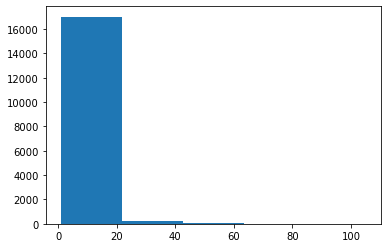

In [33]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(numbers_of_children, bins=5)

In [30]:
len(numbers_of_children)

17262

In [29]:
numbers_of_children = [value for value in numbers_of_children if value != 0.0]

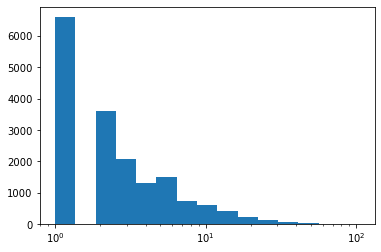

In [34]:
hist, bins = np.histogram(numbers_of_children, bins=15)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(numbers_of_children, bins=logbins)
plt.xscale('log')
plt.show()
None

In [21]:
import numpy as np
np.histogram(numbers_of_children, bins=len(set(numbers_of_children)))

(array([51672,  5661,  1306,  1506,   448,   513,   209,   285,   155,
           77,   105,    38,    79,    23,    55,    31,    20,    29,
           11,    18,     7,    13,     7,     5,    10,     2,     6,
            2,     5,     8,     2,     1,     0,     4,     0,     4,
            1,     1,     1,     0,     2,     1,     0,     0,     0,
            0,     0,     2,     1,     1,     0,     2,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     1,     1,
            0,     0,     0,     2]),
 array([  0.        ,   1.56716418,   3.13432836,   4.70149254,
          6.26865672,   7.8358209 ,   9.40298507,  10.97014925,
         12.53731343,  14.10447761,  15.67164179,  17.23880597,
         18.80597015,  20.37313433,  21.94029851,  23.50746269,
         25.07462687,  26.64179104,  28.20895522,  29.7761194 ,
         31.34328358,  32.91044776,  34.47761194,  36.04477612,
         37.6119403 ,  39.17910448,  40.74626866,  42.31343284,
         43.88059

In [107]:
from typing import Dict
import torch
import torchmetrics
from torch import nn
import pytorch_lightning as pl
import torch.nn.functional as F


class CascadeMeSH(pl.LightningModule):
    def __init__(self, mesh_tree: MeSHTree):
        super().__init__()
        self.mesh_tree = mesh_tree
        self.classifiers: Dict[Optional[str], nn.Sequential] = {}
        for node in mesh_tree.iter_without_leafs():
            self.classifiers[node.tree_number] = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32 * 32 * 3, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, len(node.children_nodes) + 1),
                nn.Threshold(0.7, 0.0)
            )
        # Initialize layers
        self.loss_fct = F.cross_entropy
        self.train_accuracy = torchmetrics.Accuracy()
        self.test_accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        clfs = [[self.classifiers.get(None)]] * x.size(0)
        labels = [[]] * x.size(0)
        tree = self.mesh_tree
        stop = False
        while not stop:
            preds = torch.tensor([[clf(xi) for clf in my_clfs] for my_clfs, xi in zip(clfs, x)])
            # new indices
            all_indices = []
            for x_index, pred in enumerate(preds):
                for my_pred in pred:
                    indices = []
                    for i, indicator in enumerate(my_pred):
                        if indicator > 0:
                            if i == 0:
                                # add to labels
                                label = None # todo extract label from tree
                                labels[x_index].append(label)
                            indices.append(i)
                # new labels

            # new clfs

        return labels

    def training_step(self, batch, batch_idx, mem1=None):
        if not mem1:
            mem1 = self.mem1
        x, y = batch
        cur, mem1_after = self.forward(x, mem1)
        loss = self.loss_fct(cur, y)
        self.log("train_loss", loss, prog_bar=True)
        self.train_accuracy(cur, y)
        self.log("train_acc", self.train_accuracy.compute(), prog_bar=True)
        return {'loss': loss, 'mem1': mem1_after}

    # def validation_step(self, batch, batch_idx):
    #     x, y = batch
    #     spk, mem = self.forward(x)
    #     loss = self.loss_fct(mem, y)
    #     self.log("val_loss", loss, prog_bar=True)
    #     return {'loss': loss}

    def test_step(self, batch, batch_idx, mem1=None):
        if not mem1:
            mem1 = self.mem1
        x, y = batch
        cur, mem1_after = self.forward(x, mem1)
        loss = self.loss_fct(cur, y)
        self.log("test_loss", loss, prog_bar=True)
        self.test_accuracy(cur, y)
        self.log("test_acc", self.test_accuracy.compute(), prog_bar=True)
        return {'loss': loss, 'mem1': mem1_after}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [108]:
from pytorch_lightning.callbacks import ModelCheckpoint

ib_data_module = MyDataModule(
    train_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshIB/TrainTitleIB.csv',
    test_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshIB/TestTitleIB.csv',
    train_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshIB/TrainTitleIBClass.csv',
    test_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshIB/TestTitleIBClass.csv'
)
b_data_module = MyDataModule(
    train_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshB/TrainTitleB.csv',
    test_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshB/TestTitleB.csv',
    train_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshB/TrainTitleBClass.csv',
    test_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshB/TestTitleBClass.csv'
)
ng_data_module = MyDataModule(
    train_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/20NewsgroupShort/TrainShortBydate.csv',
    test_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/20NewsgroupShort/TestShortBydate.csv',
    train_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/20NewsgroupShort/TrainShortBydateClass.csv',
    test_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/20NewsgroupShort/TestShortBydateClass.csv'
)

In [109]:
model_ng = SpikeText(num_inputs=ng_data_module.num_inputs, num_hidden=1000, beta=0.85,
                     num_outputs=ng_data_module.num_outputs, learning_rate=1e-4)
model_ib = SpikeText(num_inputs=ib_data_module.num_inputs, num_hidden=1000, beta=0.85,
                     num_outputs=ib_data_module.num_outputs, learning_rate=1e-4)
model_b = SpikeText(num_inputs=b_data_module.num_inputs, num_hidden=1000, beta=0.85,
                    num_outputs=b_data_module.num_outputs, learning_rate=1e-4)

In [110]:
checkpoint_callback = ModelCheckpoint(
    monitor="train_acc",
    dirpath='lightning_logs',
    filename="{epoch:02d}-{train_acc:.2f}",
)

In [111]:
ib_trainer = pl.Trainer(default_root_dir='lightning_logs',
                        max_epochs=1, gpus=torch.cuda.device_count(),
                        callbacks=[checkpoint_callback])
b_trainer = pl.Trainer(default_root_dir='lightning_logs',
                       max_epochs=1, gpus=torch.cuda.device_count(),
                       callbacks=[checkpoint_callback])
ng_trainer = pl.Trainer(default_root_dir='lightning_logs',
                        max_epochs=1, gpus=torch.cuda.device_count(),
                        callbacks=[checkpoint_callback])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [72]:
training_sets = [(model_ng, ng_data_module, ng_trainer), (model_b, b_data_module, b_trainer),
                 (model_ib, ib_data_module, ib_trainer)]
for model, data_module, trainer in training_sets:
    trainer.fit(model, datamodule=data_module)


  | Name           | Type     | Params
--------------------------------------------
0 | fc1            | Linear   | 752 K 
1 | lif1           | Leaky    | 0     
2 | fc2            | Linear   | 20.0 K
3 | train_accuracy | Accuracy | 0     
4 | test_accuracy  | Accuracy | 0     
--------------------------------------------
772 K     Trainable params
0         Non-trainable params
772 K     Total params
3.088     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]


  | Name           | Type     | Params
--------------------------------------------
0 | fc1            | Linear   | 1.6 M 
1 | lif1           | Leaky    | 0     
2 | fc2            | Linear   | 15.0 K
3 | train_accuracy | Accuracy | 0     
4 | test_accuracy  | Accuracy | 0     
--------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.484     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]


  | Name           | Type     | Params
--------------------------------------------
0 | fc1            | Linear   | 1.6 M 
1 | lif1           | Leaky    | 0     
2 | fc2            | Linear   | 15.0 K
3 | train_accuracy | Accuracy | 0     
4 | test_accuracy  | Accuracy | 0     
--------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.484     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [73]:
for model, data_module, trainer in training_sets:
    trainer.test(model, datamodule=data_module)

/usr/local/anaconda3/envs/indexing/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.08134832233190536, 'test_loss': 4.655596733093262}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3523232638835907, 'test_loss': 2.026945114135742}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3480547368526459, 'test_loss': 2.051805257797241}
--------------------------------------------------------------------------------


In [82]:
class Perceptron(pl.LightningModule):
    def __init__(self, num_inputs, num_hidden, num_outputs, learning_rate):
        super().__init__()
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lr = learning_rate
        self.loss_fct = F.cross_entropy
        self.train_accuracy = torchmetrics.Accuracy()
        self.test_accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        cur1 = self.fc1(x)
        cur2 = self.fc2(cur1)
        return cur2

    def training_step(self, batch, batch_idx):
        x, y = batch
        cur = self.forward(x)
        loss = self.loss_fct(cur, y)
        self.log("train_loss", loss, prog_bar=True)
        self.train_accuracy(cur, y)
        self.log("train_acc", self.train_accuracy.compute(), prog_bar=True)
        return {'loss': loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        cur = self.forward(x)
        loss = self.loss_fct(cur, y)
        self.log("test_loss", loss, prog_bar=True)
        self.test_accuracy(cur, y)
        self.log("test_acc", self.test_accuracy.compute(), prog_bar=True)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [83]:
ib_data_module = MyDataModule(
    train_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshIB/TrainTitleIB.csv',
    test_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshIB/TestTitleIB.csv',
    train_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshIB/TrainTitleIBClass.csv',
    test_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshIB/TestTitleIBClass.csv'
)
b_data_module = MyDataModule(
    train_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshB/TrainTitleB.csv',
    test_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshB/TestTitleB.csv',
    train_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshB/TrainTitleBClass.csv',
    test_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/TitleMeshB/TestTitleBClass.csv'
)
ng_data_module = MyDataModule(
    train_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/20NewsgroupShort/TrainShortBydate.csv',
    test_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/20NewsgroupShort/TestShortBydate.csv',
    train_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/20NewsgroupShort/TrainShortBydateClass.csv',
    test_classes_path='/Users/wojciechsitek/Documents/Indexing/code/indexingcode/data/DatasetsPM/20NewsgroupShort/TestShortBydateClass.csv'
)

In [85]:
ng_mlp_model = Perceptron(num_inputs=ng_data_module.num_inputs, num_hidden=1000,
                          num_outputs=ng_data_module.num_outputs, learning_rate=1e-4)
ib_mlp_model = Perceptron(num_inputs=ib_data_module.num_inputs, num_hidden=1000,
                          num_outputs=ib_data_module.num_outputs, learning_rate=1e-4)
b_mlp_model = Perceptron(num_inputs=b_data_module.num_inputs, num_hidden=1000,
                         num_outputs=b_data_module.num_outputs, learning_rate=1e-4)

checkpoint_callback = ModelCheckpoint(
    monitor="train_acc",
    dirpath='lightning_logs',
    filename="{epoch:02d}-{train_acc:.2f}",
)
mlp_trainer_ib = pl.Trainer(default_root_dir='lightning_logs',
                            max_epochs=5, gpus=torch.cuda.device_count(),
                            callbacks=[checkpoint_callback])
mlp_trainer_b = pl.Trainer(default_root_dir='lightning_logs',
                           max_epochs=5, gpus=torch.cuda.device_count(),
                           callbacks=[checkpoint_callback])
mlp_trainer_ng = pl.Trainer(default_root_dir='lightning_logs',
                            max_epochs=5, gpus=torch.cuda.device_count(),
                            callbacks=[checkpoint_callback])

mlp_training_sets = [(ng_mlp_model, ng_data_module, mlp_trainer_ng), (ib_mlp_model, ib_data_module, mlp_trainer_ib),
                     (b_mlp_model, b_data_module, mlp_trainer_b)]

for mlp_model, mlp_data_module, mlp_trainer in mlp_training_sets:
    mlp_trainer.fit(mlp_model, datamodule=mlp_data_module)
    mlp_trainer.test(mlp_model, datamodule=mlp_data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name           | Type     | Params
--------------------------------------------
0 | fc1            | Linear   | 752 K 
1 | fc2            | Linear   | 20.0 K
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
--------------------------------------------
772 K     Trainable params
0         Non-trainable params
772 K     Total params
3.088     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.006094762589782476, 'test_loss': 4.882161617279053}
--------------------------------------------------------------------------------



  | Name           | Type     | Params
--------------------------------------------
0 | fc1            | Linear   | 1.6 M 
1 | fc2            | Linear   | 15.0 K
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
--------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.484     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3267398178577423, 'test_loss': 2.287667751312256}
--------------------------------------------------------------------------------



  | Name           | Type     | Params
--------------------------------------------
0 | fc1            | Linear   | 1.6 M 
1 | fc2            | Linear   | 15.0 K
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
--------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.484     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/anaconda3/envs/indexing/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.36403772234916687, 'test_loss': 2.2534267902374268}
--------------------------------------------------------------------------------


In [93]:
from sklearn import tree
from sklearn.metrics import accuracy_score

for data_module in [ng_data_module, ib_data_module, b_data_module]:
    X = data_module.train_data
    y = data_module.train_classes
    clf = tree.DecisionTreeClassifier()
    clf.fit(X, y)
    pred = clf.predict(data_module.test_data)
    print("RESULT:", accuracy_score(data_module.test_classes, pred))

ValueError: Found input variables with inconsistent numbers of samples: [7532, 751]

In [99]:
len(ng_data_module.test_data)

751

In [94]:
from sklearn.linear_model import LogisticRegressionCV

# for data_module in [ng_data_module, ib_data_module, b_data_module]:
data_module = ng_data_module
X = data_module.train_data
y = data_module.train_classes
lrcv = LogisticRegressionCV()
lrcv.fit(X, y)
lrcv_pred = lrcv.predict(data_module.test_data)
print("RESULT:", accuracy_score(data_module.test_classes, lrcv_pred))

/usr/local/anaconda3/envs/indexing/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/anaconda3/envs/indexing/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

ValueError: Found input variables with inconsistent numbers of samples: [7532, 751]